![](exercise_5_8_1.png)
![](exercise_5_8_2.png)
![](off_policy_mc_control.png)

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import HTML
from IPython.display import clear_output
from math import sqrt
import matplotlib.pyplot as plt
import ipdb
import pandas as pd
import numpy as np
from itertools import product
import random
from matplotlib.animation import FuncAnimation

DEBUG = False

# NB: MAP is row, columns, but we want (x, y) which is the reverse.
MAP = pd.read_csv('maps/map1.csv', header=None).values
CELL_TYPE_MAP = {
    0: 'WALL',
    1: 'TRACK',
    2: 'GOAL',
    3: 'START',
}
MAX_Y = MAP.shape[0] - 1
MAX_X = MAP.shape[1] - 1
MAX_VELOCITY = 5

GAMMA = 0.5
EPSILON = 0.01
MAX_ITERATIONS = 5000


def states():
    """Generates all possible states.
    """
    for x, y, dx, dy in product(
        range(MAX_X + 1), range(MAX_Y + 1), range(0, MAX_VELOCITY + 1), range(0, MAX_VELOCITY + 1)
    ):
        yield (x, y, dx, dy)
        

def cell_type(state):
    """Cell types is given by values of CELL_TYPE_MAP.
    """
    assert is_valid_state(state), f'The input state is invalid, state: {state}'
    
    x, y, dx, dy = state
    return CELL_TYPE_MAP[MAP[MAX_Y - y, x]]

        
START_STATES = list(set(map(
    lambda state: (state[0], state[1], 0, 0),
    filter(
        lambda state: cell_type(state) == 'START', 
        states()
    )
)))

        
def is_valid_state(state):
    x, y, dx, dy = state
    valid_x = (0 <= x <= MAX_X)
    valid_y = (0 <= y <= MAX_Y)
    valid_dx = (0 <= dx <= MAX_VELOCITY)
    valid_dy = (0 <= dy <= MAX_VELOCITY)
    return valid_x and valid_y and valid_dx and valid_dy


def is_valid_action(action):
    return 0 <= max(map(abs, action)) <= 1 


def actions(state):
    """Generate all velocity vectors at a given state.
    """
    assert is_valid_state(state), f'The input state is invalid, state: {state}'
    
    for ddx in [-1, 0, 1]:
        for ddy in [-1, 0, 1]:
            
            action = (ddx, ddy)
            new_state = move_car(state, action)
            
            if not is_valid_state(new_state):
                continue
                
            if cell_type(new_state) == 'WALL':
                continue
             
            yield (ddx, ddy)
            

def move_car(state, action):
    """Move a car using the velocity vector.
    """
    assert is_valid_state(state), f'The input state is invalid, state: {state}'
    assert is_valid_action(action), f'The input action is invalid, action: {action}'
    
    x, y, dx, dy = state
    ddx, ddy = action
    
    new_dx = dx + ddx
    new_dy = dy + ddy
    
    new_x = x + new_dx
    new_y = y + new_dy
    
    new_state = (new_x, new_y, new_dx, new_dy)
    
    assert is_valid_state(state), f'The output state is invalid, new_state: {new_state}'
    
    return new_state
            


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def track_progress(iteration, episode_length, epsilon):
    clear_output(wait = True)
    print(
        f'Episode number: {iteration}\n'
        f'Episode length: {episode_length}\n'
        f'Epsilon: {epsilon}'
    )

def off_policy_mc_control():
    
    action_value = {}
    normalizing_constant = {}
    target_policy = {}  # The target policy is the greedy policy.
    epsilon = EPSILON
    
    # Used to track progress.
    iteration = 1

    while True:
            
        def behaviour_policy(state):
            if random.random() <= epsilon:
                return random.choice(list(actions(state)))
            return target_policy.get(state, random.choice(list(actions(state))))
        
        
        start_state = random.choice(START_STATES)
        episode = run_episode(behaviour_policy, start_state)
        episode = list(reversed(episode))
        
        G = 0.0
        W = 1.0
        
        # Used to track progress.
        episode_length = 1
        
        # Iterate in tuples (t + 1, t)
        for (new_state, new_action, new_reward), (state, action, reward) in zip(episode, episode[1:]):
            
            G = GAMMA * G + new_reward
            
            normalizing_constant[(state, action)] = normalizing_constant.get((state, action), 0) + W
            
            # The action_value is initialized as -10 by defaulting to that.
            action_value[(state, action)] = (
                action_value.get((state, action), -10) +
                W / normalizing_constant[(state, action)] * (G - action_value.get((state, action), -10))
            )
            
            target_policy[state] = best_action(state, action_value)
            
            if action != target_policy[state]:
                break
            
            # TODO: Below does not make sense.
            if action == target_policy[state]:
                W = W / (1 - epsilon + epsilon / len(list(actions(state))))
            else:
                W = W / (epsilon / len(list(actions(state))))
            
            episode_length += 1
            
            
        track_progress(iteration, episode_length, epsilon)
        iteration += 1
        
        # TODO: Break bases on a nicer stopping criteria.
        if iteration > MAX_ITERATIONS:
            break
    
    return target_policy, action_value, normalizing_constant

def run_episode(behaviour_policy, start_state):
    """Used to generate an episode.
    
    Remember:
        state -> action -> reward -> ...
    """
    
    # Initialize episode at start state, the 0 action, and 0 reward.
    state = start_state
    episode = []
    
    while True:
        
        action = behaviour_policy(state)
        
        episode.append(
            (state, action, -1)
        )
        
        state = move_car(state, action)
        
        
        # If no actions are available from state, then reset.
        if len(list(actions(state))) == 0:
            state = random.choice(START_STATES)
            episode = []
            
        # If in goal then add a goal state, the action is (-10, -10).
        if cell_type(state) == 'GOAL':
            episode.append(
                (state, (-10, -10), -1)
            )
            break
            
    return episode


def best_action(state, action_value):
    """Returns the best action in a state using the action values.
    """
    state_action_value = [(action_value.get((state, action), -10), action) for action in actions(state)]
    best_action = max(state_action_value)[1]
    
    assert isinstance(best_action, tuple), f'best_action: {best_action}'
    return best_action

In [56]:
action_value

{((14, 31, 1, 0), (0, 0)): -1.0,
 ((13, 31, 1, 0), (0, 0)): -1.5,
 ((12, 31, 0, 0), (1, 0)): -1.75,
 ((12, 31, 1, 0), (-1, 0)): -1.875,
 ((11, 31, 0, 0), (1, 0)): -1.9375,
 ((11, 31, 0, 1), (0, -1)): -1.96875,
 ((11, 30, 1, 2), (-1, -1)): -1.9720181447395944,
 ((10, 28, 1, 3), (0, -1)): -1.9860090723697972,
 ((9, 25, 1, 3), (0, 0)): -1.8820582764597915,
 ((8, 22, 0, 2), (1, 1)): -1.9444273331079427,
 ((8, 20, 0, 2), (0, 0)): -1.9736430069426782,
 ((8, 18, 0, 2), (0, 0)): -1.986721456584029,
 ((8, 16, 0, 2), (0, 0)): -1.9933972039651648,
 ((8, 14, 1, 2), (-1, 0)): -1.996699739853169,
 ((7, 12, 0, 3), (1, -1)): -1.9983498699265843,
 ((7, 9, 0, 3), (0, 0)): -1.9991630776855247,
 ((7, 6, 0, 2), (0, 1)): -1.9995815388427618,
 ((7, 4, 0, 1), (0, 1)): -1.9997346555830047,
 ((7, 3, 0, 1), (0, 0)): -1.9999052671266924,
 ((7, 2, 0, 0), (0, 1)): -1.9999595468085476,
 ((7, 2, 1, 0), (-1, 0)): -1.9999800158025796,
 ((6, 2, 0, 0), (1, 0)): -1.9999830145405249,
 ((6, 2, 0, 1), (0, -1)): -1.9999915072

# Tests

In [50]:
# Run episodes from all starting points.
for start_state in START_STATES:
    def exploring_policy(state):
        return random.choice(list(actions(state)))
    episode = run_episode(exploring_policy, start_state)

# For whatever state does shit then make sense.
for state in states():
    
    assert len(list(actions(state))) <= 9, f"state: {state}, action: {action}, new_state: {new_state}."
    assert cell_type(state) in CELL_TYPE_MAP.values(), f"state: {state}, action: {action}, new_state: {new_state}."
    
    for action in actions(state):
        
        new_state = move_car(state, action)
        new_x, new_y, new_dx, new_dy = new_state
        
        assert 0 <= new_x <= MAX_X, f"state: {state}, action: {action}, new_state: {new_state}."
        assert 0 <= new_y <= MAX_Y, f"state: {state}, action: {action}, new_state: {new_state}."
        
        assert 0 <= new_dx <= MAX_VELOCITY, f"state: {state}, action: {action}, new_state: {new_state}."
        assert 0 <= new_dy <= MAX_VELOCITY, f"state: {state}, action: {action}, new_state: {new_state}."
        
        assert cell_type(new_state) in CELL_TYPE_MAP.values(), (
            f"state: {state}, action: {action}, new_state: {new_state}."
        )

# Plotting

In [51]:
def plot_episode(fig, episode):
    """Statically plot single episode.
    """
    reconstructed_episode = reconstruct_last_episode(episode)
    buffer = 1
    ax = plt.axes(xlim=(-buffer, MAX_X + buffer), ylim=(-buffer, MAX_Y + buffer))
    for i in range(len(reconstructed_episode)-1):
        animate(i, reconstructed_episode)
    plot_walls()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, MAX_X + 1, 1))
    ax.set_yticks(np.arange(0, MAX_Y + 1, 1))
    plt.grid(True)
    

def animate_episode(i, episode):
    reconstructed_episode = reconstruct_last_episode(episode)
    return animate(i, reconstructed_episode)


def reconstruct_last_episode(episode):
    """Reconstuct a path.
    """
    res = []
    at_starting_state = False
    for state_action_reward in reversed(episode):
        state, _, _ = state_action_reward
        x, y, dx, dy = state
        res.append(
            [x, y]
        )   
    
    return list(reversed(res))

def plot_walls():
    """Plot the walls in the map.
    """
    for x, y in set(map(
            lambda state: (state[0], state[1]),
            filter(
                lambda state: cell_type(state) == 'WALL',
                list(states())
            )
        )):
        plt.plot([x], [y], marker='o', markersize=3, color="black")


def animate(i, reconstructed_episode):
    """Used to animate the plot.
    """
    [[x1, y1], [x2, y2]] = reconstructed_episode[i:int(i+2)]
    
    plt.plot([x1,x2],[y1,y2], 'r')
    
    if cell_type((x1, y1, 0, 0)) == 'START':
        plt.plot(x1, y1, 'g*')
    
    if cell_type((x2, y2, 0, 0)) == 'GOAL':
        plt.plot(x2, y2, 'r*')

# Run the algorithm and analyze output

In [52]:
target_policy, action_value, normalizing_constant = off_policy_mc_control()

Episode number: 5000
Episode length: 15
Epsilon: 0.01


In [53]:
assert all(map(lambda state: state in target_policy.keys(), START_STATES)), (
    'All the start states should be in the keys of the policy.'
)

# Race mate

START : state: (7, 0, 0, 0)    action: (0, 1)         accumulated_reward: -1   
TRACK : state: (7, 1, 0, 1)    action: (0, 1)         accumulated_reward: -2   
TRACK : state: (7, 3, 0, 2)    action: (1, -1)        accumulated_reward: -3   
TRACK : state: (8, 4, 1, 1)    action: (-1, 1)        accumulated_reward: -4   
TRACK : state: (8, 6, 0, 2)    action: (0, 1)         accumulated_reward: -5   
TRACK : state: (8, 9, 0, 3)    action: (0, 1)         accumulated_reward: -6   
TRACK : state: (8, 13, 0, 4)   action: (0, 1)         accumulated_reward: -7   
TRACK : state: (8, 18, 0, 5)   action: (0, -1)        accumulated_reward: -8   
TRACK : state: (8, 22, 0, 4)   action: (1, -1)        accumulated_reward: -9   
TRACK : state: (9, 25, 1, 3)   action: (1, 0)         accumulated_reward: -10  
TRACK : state: (11, 28, 2, 3)  action: (0, -1)        accumulated_reward: -11  
TRACK : state: (13, 30, 2, 2)  action: (-1, -1)       accumulated_reward: -12  
TRACK : state: (14, 31, 1, 1)  action: (

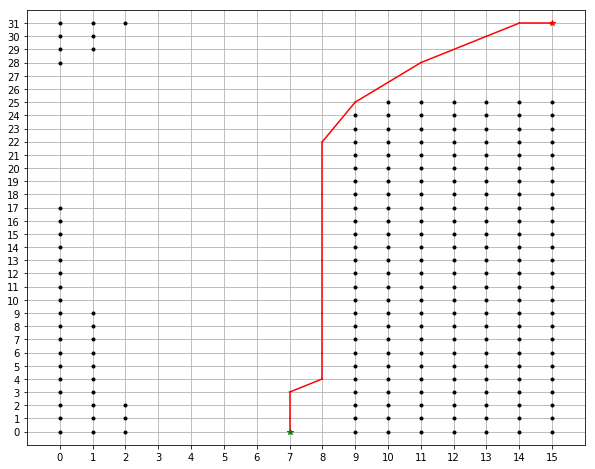

In [77]:
start_state = random.choice(START_STATES)
episode = run_episode(lambda state: target_policy[state], start_state)
accumulated_reward = 0
for state, action, reward in episode:
    accumulated_reward += reward
    
    cell_str = cell_type(state)
    state_str = f'state: {state} ' 
    action_str = f'action: {action} '
    reward_str = f'accumulated_reward: {accumulated_reward} '
    print(
         cell_str + ' ' * ( 6 - len(cell_str)) + ': '+
        (state_str + ' ' * (23 - len(state_str))) +
        (action_str + ' ' * (23 - len(action_str))) +
        (reward_str + ' ' * (25 - len(reward_str)))
    )
fig = plt.figure(figsize = (10, 8))
plot_episode(fig, episode)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


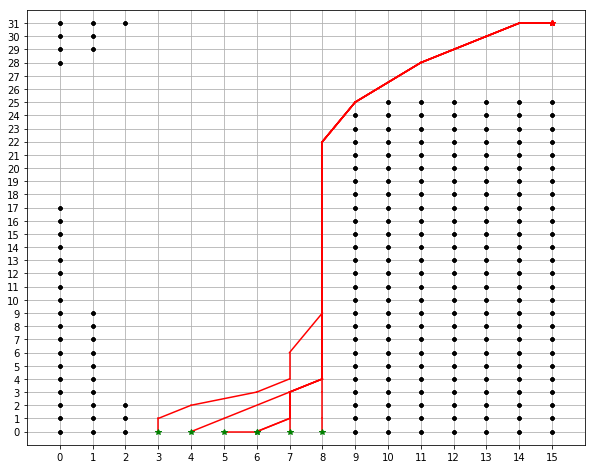

In [55]:
fig = plt.figure(figsize=(10, 8))
for start_state in START_STATES:
    episode = run_episode(lambda state: target_policy[state], start_state)
    plot_episode(fig, episode)
plt.show()

In [91]:
import numpy as np
Q = np.ones((32, 16, 6, 6, 3, 3)) * - 10

for key, val in action_value.items():
    
    
    Q[key[0][1], key[0][0], key[0][3], key[0][2], key[1][1], key[1][0]] = val

In [92]:
np.save('Q_matrix_Troels.csv', Q, allow_pickle=True, fix_imports=True)

In [90]:
Q

array([[[[[[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]]],


         [[[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ]],

          [[-10.  , -10.  , -10.  ],
           [-10.  , -10.  , -10.  ],
           [-10.  , 

In [79]:
action_value

{((14, 31, 1, 0), (0, 0)): -1.0,
 ((13, 31, 1, 0), (0, 0)): -1.5,
 ((12, 31, 0, 0), (1, 0)): -1.75,
 ((12, 31, 1, 0), (-1, 0)): -1.875,
 ((11, 31, 0, 0), (1, 0)): -1.9375,
 ((11, 31, 0, 1), (0, -1)): -1.96875,
 ((11, 30, 1, 2), (-1, -1)): -1.9720181447395944,
 ((10, 28, 1, 3), (0, -1)): -1.9860090723697972,
 ((9, 25, 1, 3), (0, 0)): -1.8820582764597915,
 ((8, 22, 0, 2), (1, 1)): -1.9444273331079427,
 ((8, 20, 0, 2), (0, 0)): -1.9736430069426782,
 ((8, 18, 0, 2), (0, 0)): -1.986721456584029,
 ((8, 16, 0, 2), (0, 0)): -1.9933972039651648,
 ((8, 14, 1, 2), (-1, 0)): -1.996699739853169,
 ((7, 12, 0, 3), (1, -1)): -1.9983498699265843,
 ((7, 9, 0, 3), (0, 0)): -1.9991630776855247,
 ((7, 6, 0, 2), (0, 1)): -1.9995815388427618,
 ((7, 4, 0, 1), (0, 1)): -1.9997346555830047,
 ((7, 3, 0, 1), (0, 0)): -1.9999052671266924,
 ((7, 2, 0, 0), (0, 1)): -1.9999595468085476,
 ((7, 2, 1, 0), (-1, 0)): -1.9999800158025796,
 ((6, 2, 0, 0), (1, 0)): -1.9999830145405249,
 ((6, 2, 0, 1), (0, -1)): -1.9999915072